  # Rusty Bargain



  El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.



  A Rusty Bargain le interesa:



  - la calidad de la predicción;



  - la velocidad de la predicción;



  - el tiempo requerido para el entrenamiento

In [3]:
# Importa librerías necesarias
import pandas as pd
import re
import numpy as np
import math
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor


  ## Carga los datos

In [4]:
# Guarda el conjunto de datos en una variable
df = pd.read_csv("datasets/autos.csv")


  ## Funciones

In [5]:

def traza_plots_condicionados (columna, columna_nombre):
    """
    Función que recibe un series (columna) y traza un plot dependiendo de la cantidad de valores únicos en la columna.
    Si la columna tiene más de 10 valores únicos traza un boxplot, si no un histograma.
    """
    if columna.nunique() < 10:
        plt.bar(columna.unique(),columna.value_counts())
        plt.xticks(columna.unique())
        plt.title(f'Gráfico de barras de {columna_nombre}.')
        plt.xlabel(f'{columna_nombre}.')
        plt.ylabel('Cantidad.')
        plt.show()
    else:
        plt.boxplot(columna, columna_nombre)
        plt.title(f'Boxplot de la distribución de {columna_nombre}.')
        plt.xlabel(f'{columna_nombre}.')
        plt.ylabel('Cantidad.')
        plt.show()

def split_camel_dromedary(string, case):
    """
    Función que aplica un split a una cadena en camel o dromedary case.
    """
    if case == 'camel':
        # Split camel case
        return re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', string)
        
    elif case == 'dromedary':
        # Split dromedary case
        return re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', string)

def IQR_calc (df, column, ):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return (Q3 + (1.5*IQR)), (Q1 - (1.5*IQR))

   

  ## Visualiza los datos

In [6]:
# Muestra la información general del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
# Imprime una muestra de los datos
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
195491,2016-04-02 19:50:42,300,sedan,1993,manual,75,golf,150000,10,petrol,volkswagen,NaN,2016-04-02 00:00:00,0,58730,2016-04-06 20:17:14
226969,2016-03-16 15:52:41,4500,small,2009,manual,75,sandero,50000,10,petrol,dacia,no,2016-03-16 00:00:00,0,36404,2016-03-23 04:56:38
311854,2016-03-18 20:47:27,6400,sedan,2006,manual,116,golf,100000,5,petrol,volkswagen,no,2016-03-18 00:00:00,0,75365,2016-03-26 11:45:31
271704,2016-04-01 17:39:18,600,NaN,2016,manual,54,other,150000,2,gasoline,citroen,no,2016-04-01 00:00:00,0,66352,2016-04-05 12:46:14
110691,2016-04-02 20:50:55,3200,wagon,2001,manual,136,3er,150000,0,NaN,bmw,no,2016-04-02 00:00:00,0,6556,2016-04-06 21:44:30


In [8]:
# Revisa la distribución de columnas con datos numéricos.
df.describe()


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


  ### Comentarios.



  - Las columnas 0, 8, 12, 13, 14, 15 no las ocupamos.



  - Cambia los nombres de las columnas para un mejor manejo.



  - Revisa el porcentaje de registros que tengan la columna "model" y "vehicle_type" con nan y de las columnas que tengan nulos o datos anomalos.



  - Elimina la columna "number_of_pictures"

  ## Preparación de datos

  ### Arregla los datos (primer parte).

In [9]:
# Elimina las columnas 0, 8, 12, 13, 14, 15 son fechas y características que no son necesarias para nuestra tarea.
df = df.drop(df.columns[[0,8,12,13,14,15]], axis=1)
# Cambia los nombres de tipo camel o snake y lower
df.columns = pd.Series(df.columns).apply(lambda x: '_'.join(split_camel_dromedary(x, 'camel')).lower())
df.rename(columns={'not_repaired':'repaired'},inplace=True)

  ### Análisis exploratorio (primer parte).

In [10]:
nombres_columnas = ['Precio','Tipo de vehículo', 'Año de matriculación', 'Caja de cambios', 'Potencia (CV)', 'Modelo', 'Kilometraje', 'Tipo de combustible', 'Marca', 'Reparado', 'Código postal']
numeric_cols_names = ['price', 'registration_year', 'power', 'kilometer', 'number_of_pictures', 'postal_code']
numeric_cols_index = [0,2,4,6,7,11]
categorical_cols_index = [1,3,5,7,9,10,11]

In [11]:
# Revisa los nombres únicos de las columnas de tipo de vehiculo y tipo de caja de cambios.
for col_name in df[['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']]:
    print(f'{col_name}:\n',df[col_name].sort_values().unique())

vehicle_type:
 ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
gearbox:
 ['auto' 'manual' nan]
fuel_type:
 ['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan]
brand:
 ['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']
repaired:
 ['no' 'yes' nan]


In [12]:
# Revisa el porcentaje de valores nulos en cada columna.
{col: [f'Datos nulos: {df[col].isnull().sum()}', f'Porcentaje: {np.round(np.mean(df[col].isnull()*100), 3)} %'] for col in df.columns if df[col].isnull().any()}

{'vehicle_type': ['Datos nulos: 37490', 'Porcentaje: 10.579 %'],
 'gearbox': ['Datos nulos: 19833', 'Porcentaje: 5.597 %'],
 'model': ['Datos nulos: 19705', 'Porcentaje: 5.561 %'],
 'fuel_type': ['Datos nulos: 32895', 'Porcentaje: 9.283 %'],
 'repaired': ['Datos nulos: 71154', 'Porcentaje: 20.079 %']}

In [13]:
# Muestra el porcentaje de valores nulos en todo el dataset.
print(f'Total de valores nulos: {np.round(np.absolute(df.dropna().count() / df.shape[0] -1)[0] *100,3)}%')


Total de valores nulos: 30.633%


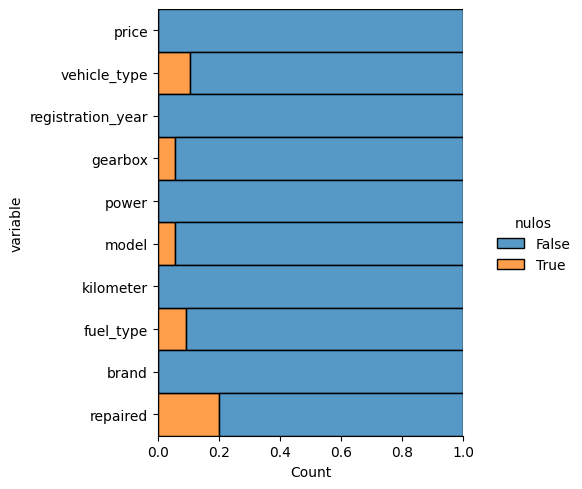

In [14]:
# Muestra un gráfico que muestre el porcentaje de nulos en cada columna
sns.displot(
    data=df.isnull().melt(value_name='nulos'),
    y='variable',
    hue='nulos',
    multiple='fill'
)


#### Comentario.



  - El 20% de datos de la columna "repaired" son nulos, representa aproximadamente la tercera parte de nuestro total de datos nulos, el predecir los datos nulos en esta columna podría ser un trabajo aparte, probemos rellenando los valores nulos con 'unknown'.



  - El total de registros con algún valor nulo es del 30%.



  - El rellenar la columna "repaired" podría dar para una tarea aparte, por ahora rellenemos los valores ausentes con 'unknown', el saber si un vehiculo tiene reparaciones podría ser independiente a las demás características.



  - No tenemos problemas de categorias duplicadas, sin embargo seguimos con el problema de los nulos, investiguemos.

  ### Arregla los datos (segunda parte).

In [15]:
# Rellena los datos nulos de la columna "repaired" con "unknown"
df['repaired'] = df['repaired'].fillna('unknown')


### Análisis exploratorio (Tercera parte)

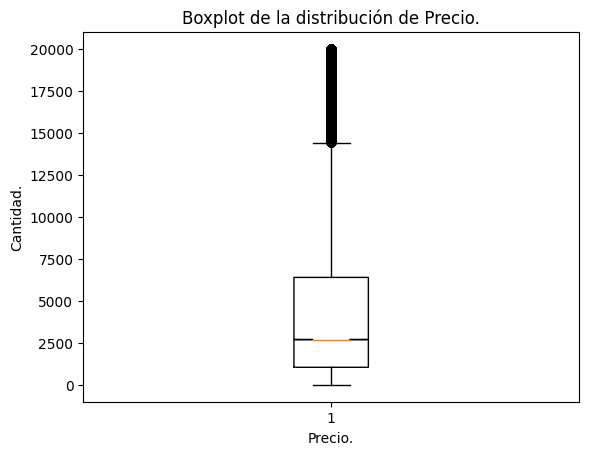

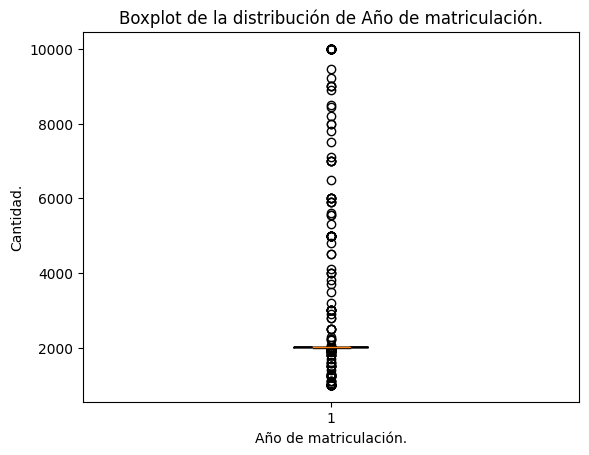

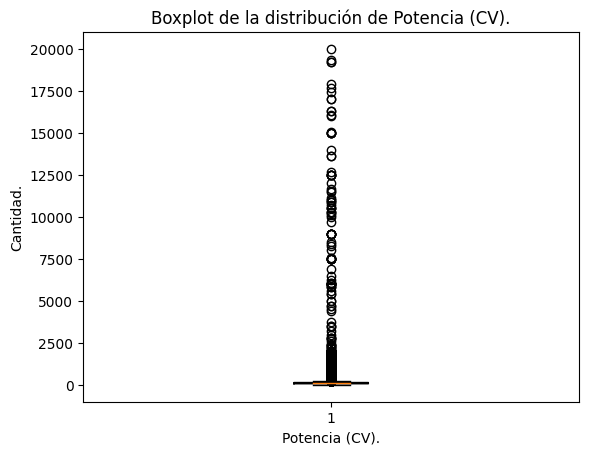

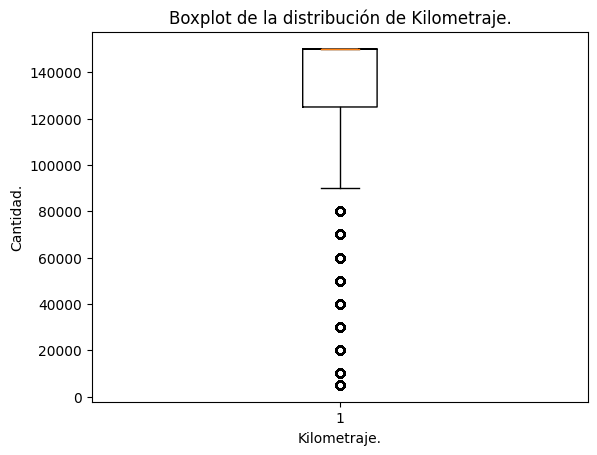

In [16]:
# Muestra gráficos para visualizar la distribución de los datos
for i in numeric_cols_index[:-2]:
    traza_plots_condicionados(df.iloc[:,i], nombres_columnas[i])


  #### Comentario.



  - En el gráfico de "price", aparentemente los precios anomalos en la parte superior son parte de los datos (no son datos anomalos), a comparación de los precios inferiores, pero no es normal que encontremos vehiculos gratuitos, investiguemos, pues el primer cuartil tiene precios bajos.



  - En el caso de la columna "registration_year" si vemos años inusuales, investiguemos el porcentaje que estos representan.



  - Parece que los usuarios tienen buen sentido del humor, visualicemos el porcentaje de vehículos por encima de los 1000CV (por debajo de esos 1000CV podríamos tener súper autos).



  - En la columna de "kilometer" vemos algunos registros con kilometraje anomalo, sin embargo a pesar que es poco usual, si podríamos encontrar un vehiculo con poco kilometraje en venta. Dejemos esta columna sin modificar los datos anomalos.

  #### Porcentaje de anomalos en "price"

In [17]:
# Calcula los niveles de los bigotes de boxplot de la columna "price"
up_lvl_price, low_lvl_price = IQR_calc(df,'price')

In [18]:
# Muestra los valores de los bigotes
print(up_lvl_price, low_lvl_price)

14425.0 -6975.0


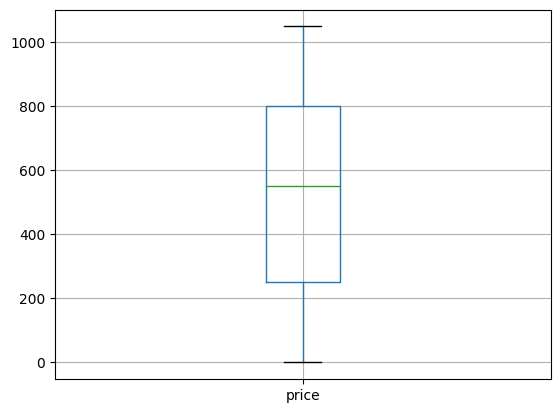

In [19]:
# Muestra un boxplot del primer cuartil de "price"
df[df['price'] < df['price'].quantile(0.25)].boxplot('price')
plt.show()

<Axes: >

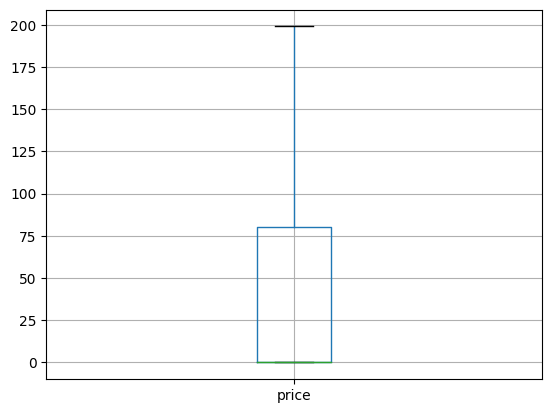

In [20]:
# Muestra un boxplot de datos menores a 200 en "price".
df[df['price'] < 200].boxplot('price')


In [21]:
# Muestra un describe de "kilometer" para la columna de "price" menor al primer cuartil
df[df['price'] < df['price'].quantile(0.25)]['kilometer'].describe()


count     88057.000000
mean     135877.102331
std       35471.831007
min        5000.000000
25%      150000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [22]:
# Muestra el porcentaje de datos por debajo del primer cuartil
df[(df['price'] < df['price'].quantile(0.25))]['price'].count() / df.shape[0] * 100

24.84895687828224

In [23]:
# Muestra el porcentaje de datos por encima del bigote superior
df[df['price'] > up_lvl_price]['price'].count() / df.shape[0]


0.05355716781095412

  #### Porcentaje de anomalos en "registration_year".

In [24]:
# Calcula los bigotes de la columna 'registration_year'
up_reg_year, low_reg_year = IQR_calc(df, 'registration_year')
# Muestra el porcentaje de vehiculos con registration_year anomalo
print("Porcentaje de vehículos con 'registration_year' anomalo: ", np.round(df.query("registration_year < @low_reg_year or registration_year > @up_reg_year")['registration_year'].count() / df.shape[0] * 100,3),'%')


Porcentaje de vehículos con 'registration_year' anomalo:  1.78 %


  #### Porcentaje de datos anomalos en "power".

In [25]:
# Calcula los niveles de los bigotes de la columna "power"
up_lvl_power, low_lvl_power = IQR_calc(df,'power')
#Muestra los niveles de los bigotes.
print("Nivel superior:", up_lvl_power, "Nivel inferior:",low_lvl_power)
# Porcentaje de vehiculos por encima del bigote superior.
print("Porcentaje de vehiculos por encima del bigote superior:",np.round(df[df['power'] > up_lvl_power]['power'].count() / df.shape[0] * 100,3),"%")
# Porcentaje de vehiculos por debajo del primer cuartil.
print("Porcentaje de vehiculos por debajo del primer valor del primer cuartil:",np.round(df[df['power'] < df['power'].quantile(0.25)]['power'].count() / df.shape[0] * 100,3),"%")
# Muestra el valor del primer cuartil
print("Valor de primer cuartil:", df['power'].quantile(0.25))



Nivel superior: 254.0 Nivel inferior: -42.0
Porcentaje de vehiculos por encima del bigote superior: 2.071 %
Porcentaje de vehiculos por debajo del primer valor del primer cuartil: 24.939 %
Valor de primer cuartil: 69.0


 ### Porcentaje de datos anomalos en "kilometer"

In [26]:
# Calcula el valor de los bigotes del boxplot de "kilometer"
up_lvl_kilometer, low_lvl_kilometer = IQR_calc(df,'kilometer')
# Muestra el valor del bigote inferior.
print(low_lvl_kilometer)
# Muestra el porcentaje de valores por debajo del bigote inferior.
print("Porcentaje de valores por debajo del bigote inferior:", np.round(df[df['kilometer']<low_lvl_kilometer]['kilometer'].count()/df.shape[0]*100,3))


87500.0
Porcentaje de valores por debajo del bigote inferior: 15.029


  #### Comentario.



  - Gran mayoría de datos del primer cuartil en la columna de "price" tiene 150,000 kilometros de recorrido, lo que explicaría el precio bajo, sin embargo, el total de datos anomalos suma aproximadamente el 29%.



  - Rellena por ahora los datos de la columna "price" por debajo del primer cuartil con la media.



  - Los datos anomalos de la columna "registration_year" representan un bajo porcentaje, conservemos los vehiculos desde el año en que se invento el primer vehiculo hasta el año actual.



  - Conservemos los vehiculos por encima del primer cuartil y hasta 1000 cv (superior al bigote superior e inferior a 1000 pudieramos tener un super auto) y rellena los datos por debajo del primer cuartil con la media.



  - El porcentaje de valores por debajo del bigote inferior de la columna "kilometer" es del 15% sin embargo, pudieran no ser valores anomalos, conservemoslos.

  ### Arregla los datos (tercera parte).

In [27]:
# Rellena los datos de "price" por debajo del primer cuartil con la media.
df.loc[df['price']<df['price'].quantile(0.25), 'price'] = df['price'].mean()
# Rellena los datos de "power" por debajo del primer cuartil con la media.
df.loc[df['power']<df['power'].quantile(0.25), 'power'] = df['power'].mean()
# Elimina los datos anomalos en la columna "registration_year"
df = df.query("registration_year > 1886 and registration_year < 2024")
df = df.query("power > power.quantile(0.25) and power < 1000")
df = df.dropna().reset_index(drop=True)


  ### Separa el df en conjuntos de entrenamiento y prueba para los distintos modelos.

In [28]:
# Dividir el dataframe en conjunto de entrenamiento validación y prueba
seed = np.random.seed(42)
X_train, X, y_train, y = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.4, random_state=seed)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

### Preprocesa el conjunto de datos para buscar el mejor modelo

In [29]:
# Crea una instancia para el codificador para la columna 'repaired' con el orden de las etiquetas y aplica fit con la columna 'repaired' del conjunto de entrenamiento.
lr_ordinal_encoder = OrdinalEncoder(categories=[["unknown", "yes", "no"]]).fit(X_train[['repaired']])
# Transforma las etiquetas del conjunto de entrenamiento
X_train[['repaired']] = lr_ordinal_encoder.transform(X_train[['repaired']])
X_train[['repaired']] = X_train[['repaired']].astype('int64')
# Transforma las etiquetas del conjunto de validación y prueba
X_valid[['repaired']] = lr_ordinal_encoder.transform(X_valid[['repaired']])
X_valid[['repaired']] = X_valid[['repaired']].astype('int64')
X_test[['repaired']] = lr_ordinal_encoder.transform(X_test[['repaired']])
X_test[['repaired']] = X_test[['repaired']].astype('int64')
# Codifica algunas caracteristicas nominales con BinaryEncoder.
cols_to_binary_encoder = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']
binary_encoder = BinaryEncoder(cols=cols_to_binary_encoder).fit(X_train[cols_to_binary_encoder])
# Crea una variable con las nuevas columnas
X_train_bin_cols = binary_encoder.transform(X_train[cols_to_binary_encoder])
X_valid_bin_cols = binary_encoder.transform(X_valid[cols_to_binary_encoder])
X_test_bin_cols = binary_encoder.transform(X_test[cols_to_binary_encoder])
# Elimina las columnas que vamos a reemplazar
X_train = X_train.drop(cols_to_binary_encoder, axis=1)
X_valid = X_valid.drop(cols_to_binary_encoder, axis=1)
X_test = X_test.drop(cols_to_binary_encoder, axis=1)
# Concatena los dataframes que reemplazan las columnas codificadas
X_train = pd.concat([X_train, X_train_bin_cols], axis=1)
X_valid = pd.concat([X_valid, X_valid_bin_cols], axis=1)
X_test = pd.concat([X_test, X_test_bin_cols], axis=1)
# Crea un transformador para las características numéricas a escalar
numeric_cols_for_scaler = ['registration_year', 'power', 'kilometer']
rob_scaler = RobustScaler().fit(X_train[numeric_cols_for_scaler])
# Escala las características numéricas con RobustScaler para que la normalización sea robusta a los datos anomalos
X_train[numeric_cols_for_scaler] = rob_scaler.transform(X_train[numeric_cols_for_scaler])
X_valid[numeric_cols_for_scaler] = rob_scaler.transform(X_valid[numeric_cols_for_scaler])
X_test[numeric_cols_for_scaler] = rob_scaler.transform(X_test[numeric_cols_for_scaler])


### Busqueda de modelo.

#### Regresión lineal.

In [30]:
# Entrena un modelo de Regresión lineal
clf_linearr = LinearRegression().fit(X_train, y_train)
# Score
predict_linearr = clf_linearr.predict(X_valid)
print('Raíz del error cuadrático medio de Regresión Lineal:', mean_squared_error(y_valid, predict_linearr, squared=False))


Raíz del error cuadrático medio de Regresión Lineal: 3198.0918636372407


c:\Users\chuch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 #### XGBoost

In [ ]:

# Crea una instancia para el modelo
clf_xgb = XGBRegressor()
# Crea un diccionario con los hiperparámetros para xgb
xgb_grid = {
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5,6,7]
}
# Pasa el modelo por GridSerachCV
xgb_gridcv = GridSearchCV(clf_xgb, xgb_grid, scoring='neg_root_mean_squared_error',verbose=30)
xgb_gridcv.fit(X_train, y_train)
# Imprime los mejores parámetros
xgb_gridcv.best_params_

In [31]:

# Entrena el modelo con los mejores parámetros
clf_xgb = XGBRegressor(learning_rate=0.07, max_depth=7).fit(X_train, y_train)
# Predice con el conjunto de validación
y_pred_xgb = clf_xgb.predict(X_valid)
# Muestra el score
print("Raíz del error cuadrático medio de XGBRegressor:", mean_squared_error(y_valid, y_pred_xgb, squared=False))


Raíz del error cuadrático medio de XGBRegressor: 1903.555753236869


c:\Users\chuch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Bosque Aleatorio.

In [29]:
# Crea una instancia del modelo.
clf_rfr = RandomForestRegressor(random_state=seed)
rfr_grid = {
    "criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "max_depth":list(range(38,49,5))
}
# Pasa el modelo por GridSearchCV.
rfr_gridscv = GridSearchCV(clf_rfr, rfr_grid, scoring='neg_root_mean_squared_error',verbose=30)
rfr_gridscv.fit(X_train, y_train) 
rfr_gridscv.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START criterion=squared_error, max_depth=38......................
[CV 1/5; 1/12] END criterion=squared_error, max_depth=38;, score=-1863.274 total time=  49.0s
[CV 2/5; 1/12] START criterion=squared_error, max_depth=38......................
[CV 2/5; 1/12] END criterion=squared_error, max_depth=38;, score=-1852.565 total time=  48.3s
[CV 3/5; 1/12] START criterion=squared_error, max_depth=38......................
[CV 3/5; 1/12] END criterion=squared_error, max_depth=38;, score=-1863.121 total time=  44.3s
[CV 4/5; 1/12] START criterion=squared_error, max_depth=38......................
[CV 4/5; 1/12] END criterion=squared_error, max_depth=38;, score=-1836.985 total time=  44.3s
[CV 5/5; 1/12] START criterion=squared_error, max_depth=38......................
[CV 5/5; 1/12] END criterion=squared_error, max_depth=38;, score=-1869.629 total time=  43.8s
[CV 1/5; 2/12] START criterion=squared_error, max_depth=43......

In [33]:
# Entrena el modelo con los mejores hiperparámetros
clf_rfr = RandomForestRegressor(criterion='poisson', max_depth=43, random_state=seed).fit(X_train, y_train)
y_pred_rfr = clf_rfr.predict(X_valid)
# Resultado
print("Raíz del error cuadrático medio de Árbol de Decisión de regresión:", mean_squared_error(y_valid, y_pred_rfr, squared=False))


Raíz del error cuadrático medio de Árbol de Decisión de regresión: 1853.6601547962464


c:\Users\chuch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  ### CatBoostClassifier

In [ ]:
# Pasa catboost por gridsearch
cat_grid = {
    'learning_rate':[0.1,0.5],
    'iterations':[150]
}
cat_model = CatBoostRegressor(loss_function='RMSE',verbose=50, random_state=seed)
grid_search_result = cat_model.grid_search(param_grid=cat_grid, X=X_train, y=y_train, train_size=0.7)
grid_search_result['params']
 


In [34]:
# Entrena el modelo con los mejores parámetros
cat_model = CatBoostRegressor(loss_function='RMSE', learning_rate=0.5, iterations=150, random_state=seed).fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_valid)
# Resultado
print("Raíz del error cuadrático medio de Árbol de CatBoostRegressor:", mean_squared_error(y_valid, y_pred_cat, squared=False))



0:	learn: 3232.5598676	total: 171ms	remaining: 25.5s
1:	learn: 2749.0329014	total: 184ms	remaining: 13.6s
2:	learn: 2539.7690974	total: 194ms	remaining: 9.53s
3:	learn: 2435.8379246	total: 207ms	remaining: 7.55s
4:	learn: 2373.8994785	total: 217ms	remaining: 6.29s
5:	learn: 2327.9212567	total: 228ms	remaining: 5.46s
6:	learn: 2310.0296505	total: 238ms	remaining: 4.86s
7:	learn: 2254.0036452	total: 251ms	remaining: 4.45s
8:	learn: 2232.2968383	total: 263ms	remaining: 4.13s
9:	learn: 2205.5935088	total: 274ms	remaining: 3.84s
10:	learn: 2150.6455203	total: 285ms	remaining: 3.6s
11:	learn: 2138.2481226	total: 295ms	remaining: 3.39s
12:	learn: 2131.0594256	total: 305ms	remaining: 3.21s
13:	learn: 2123.8146477	total: 315ms	remaining: 3.06s
14:	learn: 2113.4521941	total: 325ms	remaining: 2.92s
15:	learn: 2091.1826434	total: 336ms	remaining: 2.81s
16:	learn: 2068.0062950	total: 350ms	remaining: 2.74s
17:	learn: 2056.4166802	total: 360ms	remaining: 2.64s
18:	learn: 2042.9673382	total: 371ms	re

c:\Users\chuch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### LightGBM

In [ ]:
# Pasa el modelo por gridsearch
lgb_grid = {
    "boosting_type":['gbdt', 'dart'],
    "num_leaves":[31],
    "learning_rate":[0.5]
}
lgb_model = lgb.LGBMRegressor(metric='rmse', random_state=seed)
lgb_gscv = GridSearchCV(lgb_model, param_grid=lgb_grid, verbose=50).fit(X_train, y_train)
lgb_gscv.best_params_


In [35]:
# Entrena el modelo con los mejores parámetros
lgb_model = lgb.LGBMRegressor(metric='rmse', boosting_type='gbdt', learning_rate=0.5, num_leaves=31, random_state=seed).fit(X_train, y_train)
# Predice con el conjunto de validación
y_pred_lgb = lgb_model.predict(X_valid)
# Score
print("Raíz del error cuadrático medio de Árbol de LGBRegressor:", mean_squared_error(y_valid, y_pred_lgb, squared=False))



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 120742, number of used features: 27
[LightGBM] [Info] Start training from score 6093.285494
Raíz del error cuadrático medio de Árbol de LGBRegressor: 1855.4355809084898


c:\Users\chuch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 ### Prueba el mejor modelo

In [36]:
y_pred_lgb_test = lgb_model.predict(X_test)
# Score
print("Raíz del error cuadrático medio de Árbol de LGBRegressor para el conjunto de prueba:", mean_squared_error(y_test, y_pred_lgb_test, squared=False))

Raíz del error cuadrático medio de Árbol de LGBRegressor para el conjunto de prueba: 1839.0408033354006


c:\Users\chuch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Conclusiones.

 - Podemos mejorar nuestros modelos limpiando de mejor manera nuestras características.

 - Teniendo en cuenta la velocidad y la calidad de la predicción de nuestros modelos, podríamos elegir entre LightGBM o XGBoost.

 - LightGBM por velocidad.

 - XGBBoost por calidad de predicción.